# -- Part 2 -- PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow.

Resources:
* Ground truth notebook

In [ ]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.5.1+cu124'

## 1. Data (Preparing and Loading)

Data can be almost anything in machine learning:

* Excel spreadsheet
* Images of any kind
* Videos (Youtube...)
* Audio (songs / podcasts)
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concept in MM in general)

* **Training set** : The model learns from this data (like the course materials) -> 60 to 80% of data
* **Validation set** : The model gets tuned on this data (like the practice exam) -> 10 to 20% of data
* **Testing set** : The model gets evaluated on this data to test what it has learned -> 10 to 20% of data

Let's create a training and test set with our data

In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split] # [:train_split] = Up to train_split
X_test, y_test = X[train_split:], y[train_split:] # [train_split:] = From train_split onwards

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, tests data and compares predictions
  """
  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Testing data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions ?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

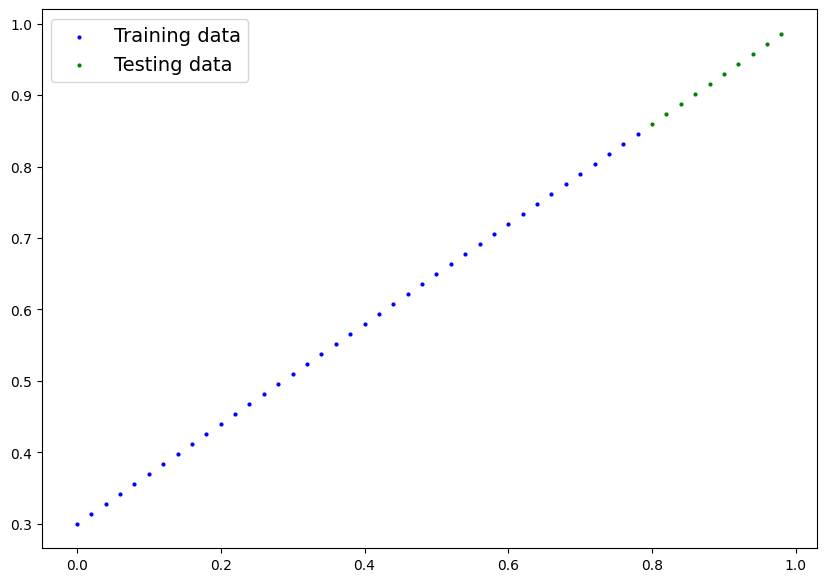

In [ ]:
plot_predictions()

## 2. Build model

Building our first PyTorch model

⚠️ Use of PYTHON CLASSES

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and bias values we used to create data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

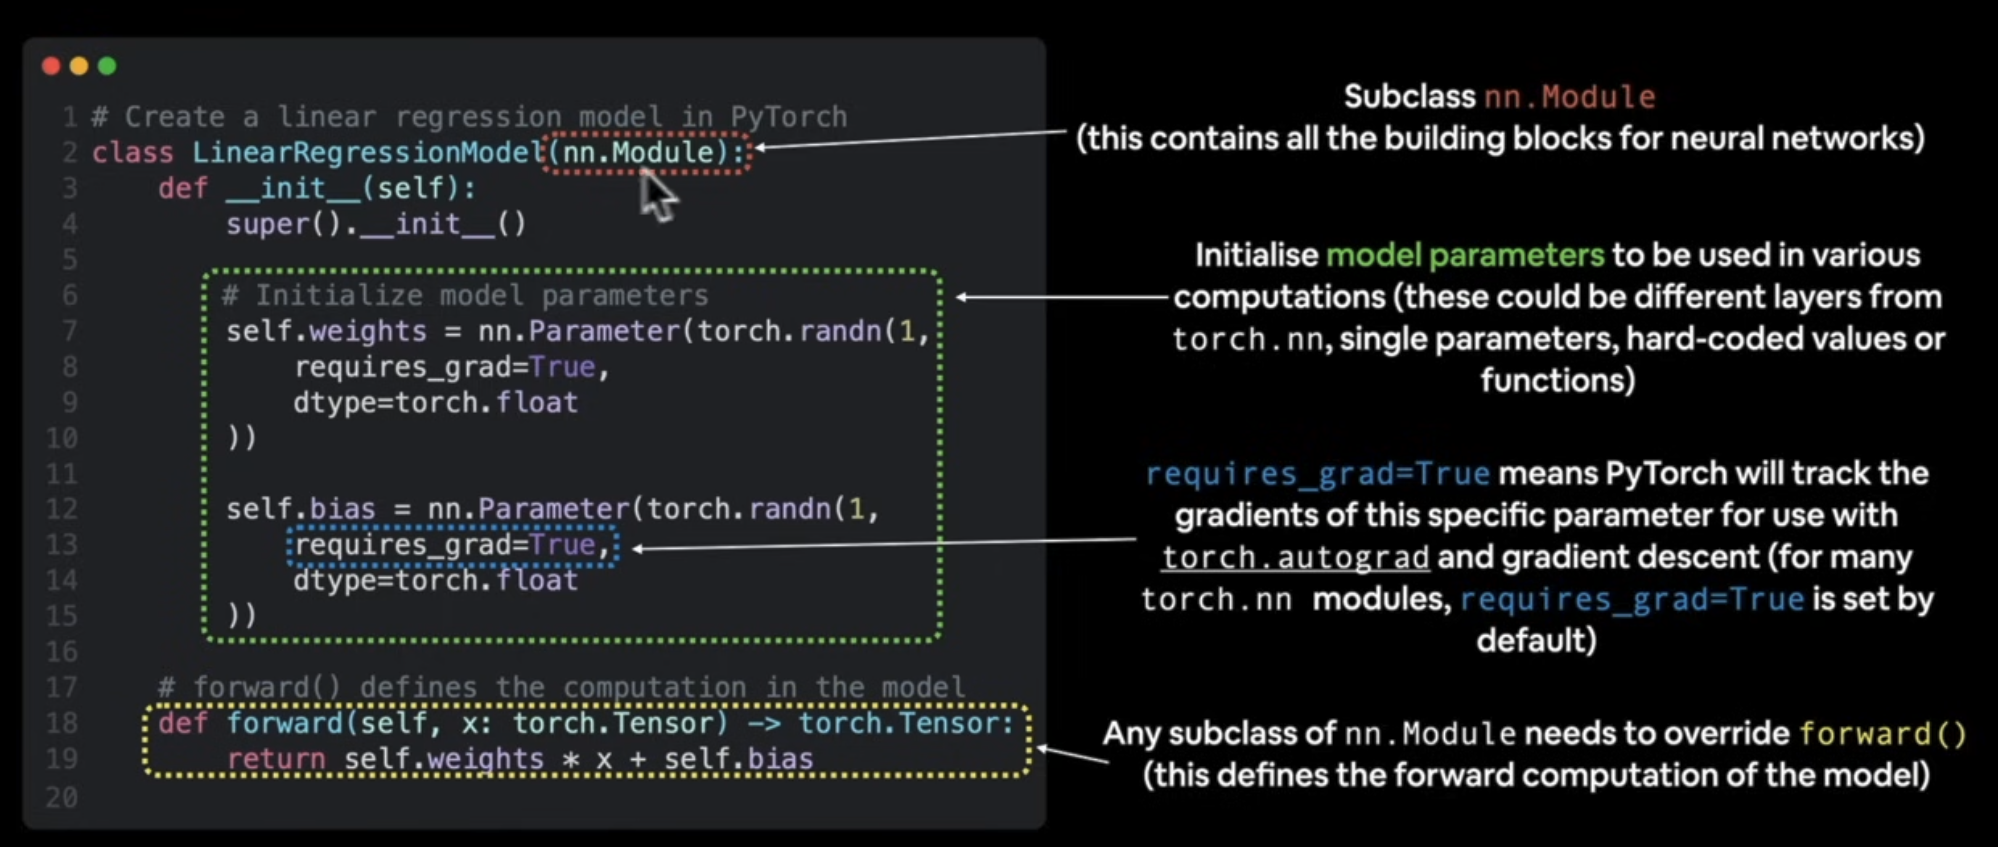

In [ ]:
import torch
from torch import nn

# Create a linear regression model class
class LinearRegressionModel(nn.Module): #Inherit from nn.Module (like almost everything in PyTorch)
  def __init__(self):
    super().__init__()
    # Generate random parameters
    self.weights = nn.Parameter(torch.randn(1, # <- starts with a random weight and adjust it to the ideal weight
                                           requires_grad=True, # (Default = True) <- can this parameter be updated via gradient descent ?
                                           dtype=torch.float)) # (Default = float) <- PyTorch prefered datatype
    self.bias = nn.Parameter(torch.randn(1, # <- starts with a random bias and adjust it to the ideal bias
                                         requires_grad=True, # (Default = True) <- can this parameter be updated via gradient descent ?
                                         dtype=torch.float)) # (Default = float) <- PyTorch prefered datatype

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is the input data
    return self.weights * x + self.bias # This is the linear regression formula

### PyTorch model building essentials

* **torch.nn** - contains all of the building block for computational graphs (a neural network can be considered a computational graph)
* **torch.nn.Parameter** - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* **torch.nn.Module** - the base class for all neural network modules, if you subclass it, you have to overwrite
* **torch.optim** - this is where the optimizers in PyTorch live, they will help with gradient descent
* **def forward()** - all `nn.Module`subclasses require you to overwrite forward(), this method defines what happens in the forward computation
* **torch.utils.data.Dataset** - Represents a map between key (label) and sample (features) pairs of your data. Such as images and their associated labels
* **torch.utils.data.DataLoader** - Creates a Python iterable over a torch Dataset (allows you to iterate over your data)

### Checking the content of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check out our model parameters or what's inside our model using `.parameters()`

In [ ]:
# Create a random seed (educational sake)
torch.manual_seed(42)

#Create an instance of the model (thisd is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List name parameters
model_0.state_dict() # much easier to read!!!

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check out model's predictive power, let's see how well it predicts `y_test`based on `X_test``

When we pass data through our model, it's going to run it through our forward() method

In [ ]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [ ]:
# Make predictions with model

with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
y_test # Not even close (random params = random predictions)

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

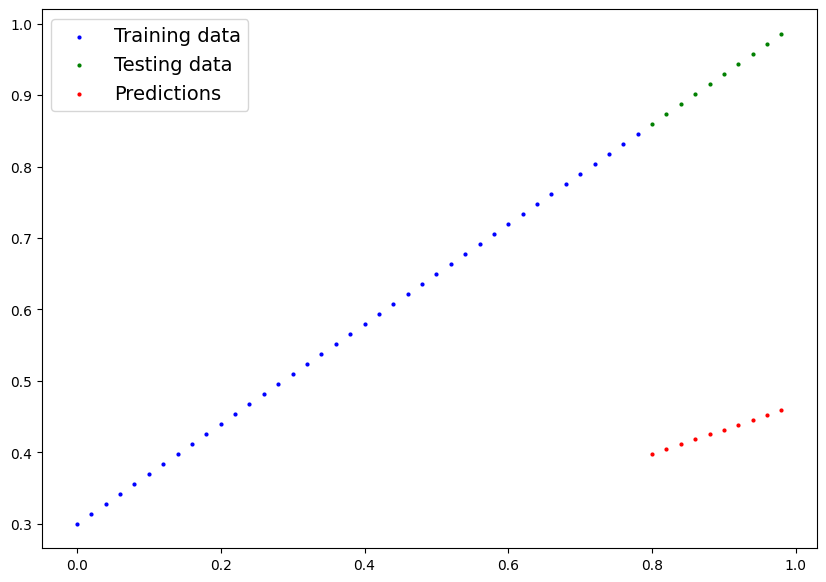

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some **unknown** parameters (these may be random) to some **known** parameters

Or in other words frol a **poor** representation of the data to a **better** representation.

One way to measure how poor or how wrong your models predictions are is to use a **loss** function

* Note : ***Loss function*** may also be called ***cost function*** or ***criterion*** in different areas. For our case we're goind to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your models predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model parameters (e.g weight & bias in our case) to improve the loss function.

  * Inside the optimizer you'll often have to set two parameters:
    * `params` - the model parameters you'd like to optmize, for example `params=model_0.parameters()``
    * `lr`(learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small `lr`results in small changes, a large `lr`results in large changes)

And scpecifically for PyTorch we need:
* A training loop
* A testing loop

> @TODO : Read the different Loss Functions & optimizers in the doc (there are a lot!) **bold text**



In [ ]:
# Check out our model's parameters (a parameter is a value that the model sets itself)

In [ ]:
# Setup a loss function (L1loss() is an average error loss function)
loss_fn = nn.L1Loss()

# Setup an optimizer (SGD = stochastic gradient descent -> is the most popular (Adam as well))
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.01, # lr = learning rate -> possibily the most important hyperparameter you can set
                            )

**Q:** Which loss function and which optimizer should I use ?

**A:** This will be problem specific. But with experience, you'll get an idea of what works and what doesn't with your particular problem set.

For example, for a regression problem (like ours), as loss function of `nn.L1Loss()`and an optimizer like `torch.optim.SGD()`will suffice.

But for a classification problem like classifying whether a photo is of a dog or a cat, you'll likely want to use a loss function of `nn.BCELoss()` (binary cross entropy loss)

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our data forward() functions to make predictions on data - AKA ***forward propagation***
2. Calculate de loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [ ]:
torch.manual_seed(42)
# An epoch is one loop through the data (this is a hyperparameter because we've set it ourselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require grandients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # By default how the optimizer changes will accumulate through the loop... so we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing  (dropout / batch layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
  #with torch.no_grad(): # You may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    #2 . Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Test: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Test: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Test: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Test: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Test: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Test: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Test: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

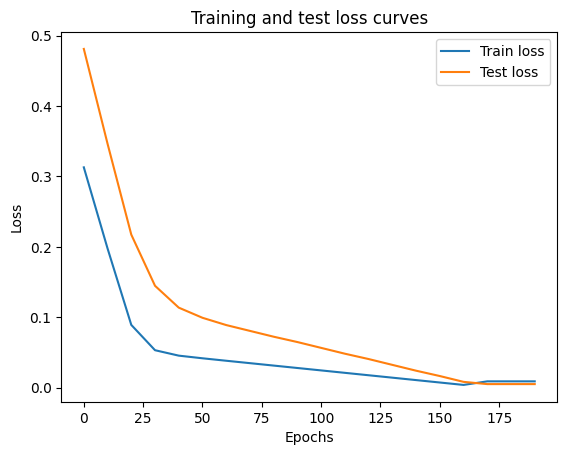

In [ ]:
import numpy as np

# Plot the loss curve
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
weight, bias

(0.7, 0.3)

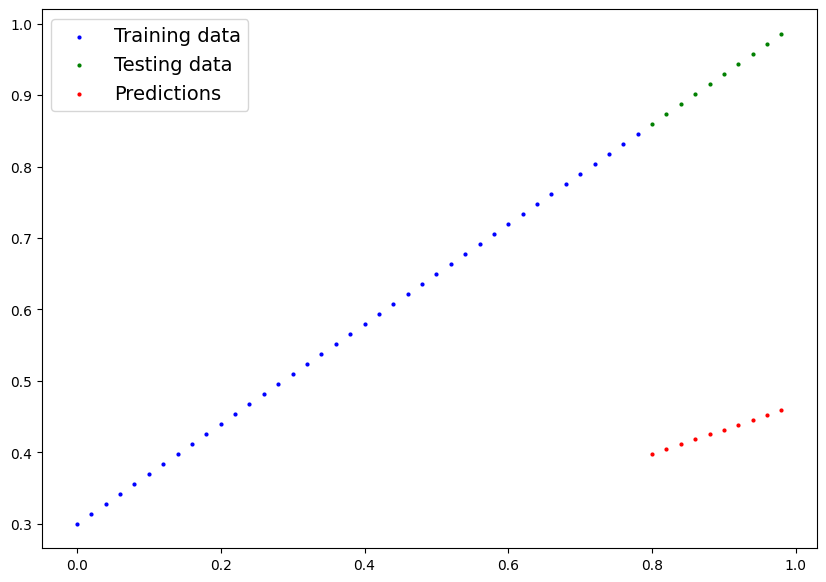

In [ ]:
plot_predictions(predictions=y_preds) # Avec la valeur random initiale

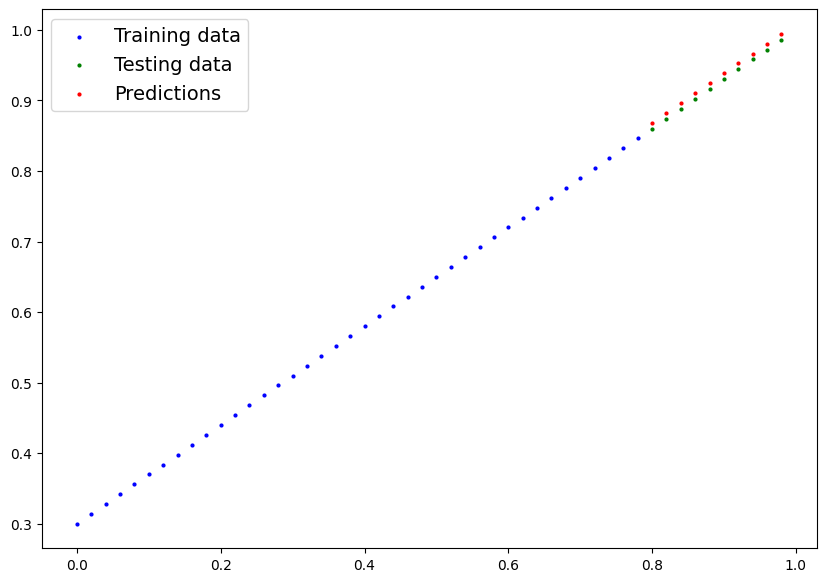

In [ ]:
plot_predictions(predictions=y_preds_new) # Après [epochs] tours de boucle

## Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in PyTorch.

1. `torch.save()`- allows you to save a PyTorch object in Python's pickle format
2. `torch.load()`- allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()`- allows to load a model's saved state dictionary

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")

torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
!ls -lah models

total 16K
drwxr-xr-x 2 root root 4.0K Feb  5 14:13 .
drwxr-xr-x 1 root root 4.0K Feb  5 13:13 ..
-rw-r--r-- 1 root root 1.7K Feb  5 14:15 01_pytorch_workflow_model_0.pth
-rw-r--r-- 1 root root 1.8K Feb  5 14:13 01_pytorch_workflow_model_1.pth


## Loading a PyTorch Model

Since we saved our model's `state_dict`rather than the entire model, we'll create a new instance of the model class and load the saved `state_dict`into that

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-127-ade34efd9648>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Make some model preds
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one place

In [ ]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.5.1+cu124'

**Create device agnostic code.**

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

**If no GPU is available, the code will default to using CPU**

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

In [ ]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # Without unsqueeze errors will pop up
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, tests data and compares predictions
  """
  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Testing data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions ?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

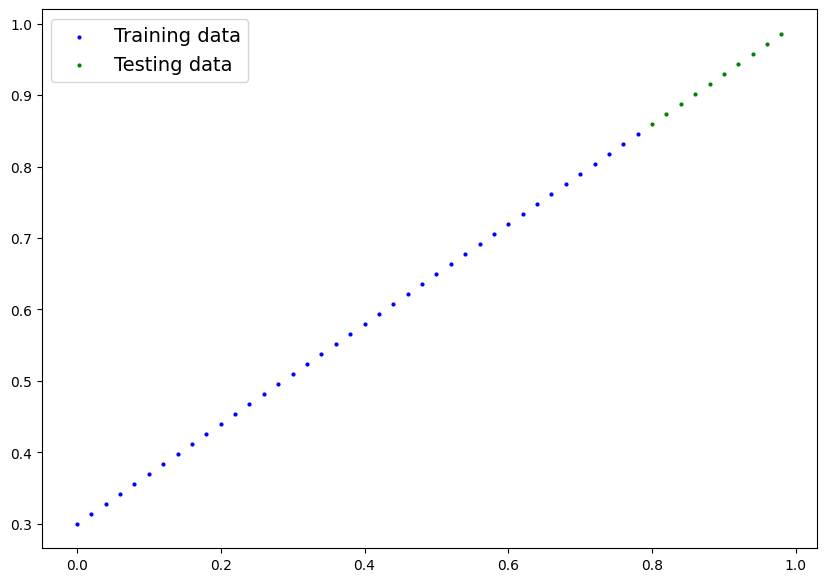

In [ ]:
# Plot the data
# Note : if you don't have the plot_predictions() function loaded, this will error
# See `def plot_prediction()` above in course
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear Model


In [ ]:
# Create a linear model by sublassing nn.Module

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer...
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [ ]:
# Set up a loss function
loss_fn = nn.L1Loss() # Same as MAE (Mean Average Error)

# Set up our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.01)

In [ ]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero_grad()
  optimizer.zero_grad() # Otherwise it accumulates gradients each loop cycle

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening

  if epoch % 10 == 0:
    print(f"Eopoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


Eopoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Eopoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Eopoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Eopoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Eopoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Eopoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Eopoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Eopoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Eopoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Eopoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Eopoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Eopoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Eopoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Eopoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.0

In [ ]:
model_1.state_dict(), weight, bias

(OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
              ('linear_layer.bias', tensor([0.3025], device='cuda:0'))]),
 0.7,
 0.3)

### 6.4 Making and evaluating predictions

In [ ]:
# Turn the model into evaluation mode
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

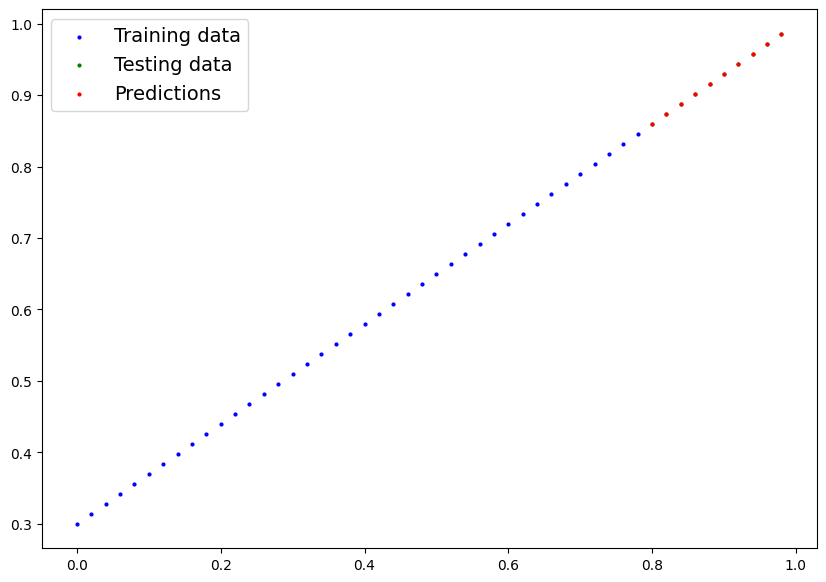

In [ ]:
# Check out our model predictions visually

plot_predictions( predictions = cpu_test_pred.cpu()) # In case the Predictions were on the GPU

### 6.5 Saving a loading a trained model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Load a PyTorch model

# Create a new instance of the Linear regression Model
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to the device
loaded_model_1.to(device)

<ipython-input-147-41bd12d54fac>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
# Evaluate loaded model
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Exercices

URL : https://learnpytorch.io/01_pytorch_workflow/#exercices

Existing model : LOADING...
Train Loss: 0.007879986427724361 | Test loss: 0.011536476202309132


<ipython-input-71-c148679e10e1>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exercise_model.load_state_dict(torch.load(MODEL_SAVE_PATH))


Saving model to: models/exercise_model.pth


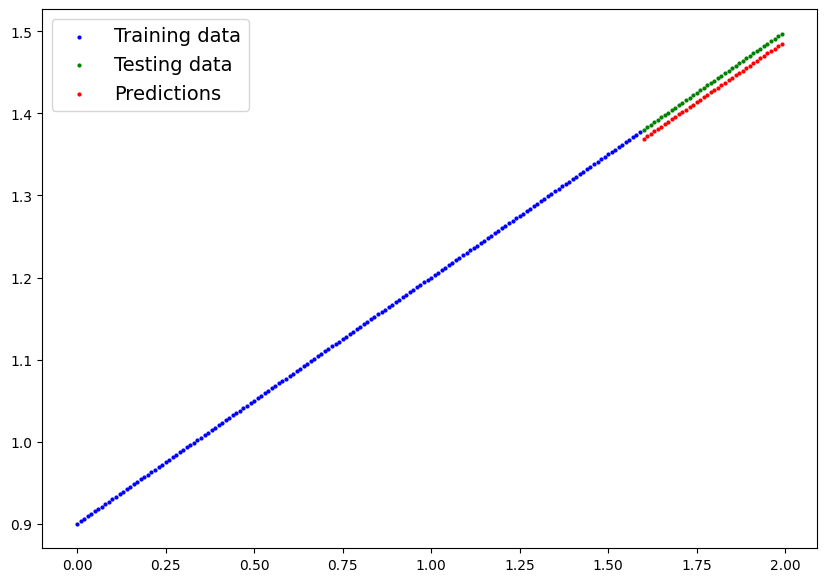

In [ ]:
# 1 - Create a straight line dataset using the linear regression formula (weight * X + bias).
  # Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
  # Split the data into 80% training, 20% testing.
  # Plot the training and testing data so it becomes visual.

# 2 - Build a PyTorch model by subclassing nn.Module.
  # Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
  # Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
  # Once you've constructed the model, make an instance of it and check its state_dict().
  # Note: If you'd like to use nn.Linear() instead of nn.Parameter() you can.

# 3 - Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.
  # Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
  # Write a training loop to perform the appropriate training steps for 300 epochs.
  # The training loop should test the model on the test dataset every 20 epochs.

# 4 - Make predictions with the trained model on the test data.
  # Visualize these predictions against the original training and testing data (note: you may need
  # to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled

# 5 - Save your trained model's state_dict() to file.
  # Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
  # Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.
  # libraries such as matplotlib to plot).

import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "exercise_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

class ExerciseLinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer...
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x):
    return self.linear_layer(x)

def plot_predictions(train_data,
                     train_labels,
                     test_data,
                     test_labels,
                     predictions=None):
  """
  Plots training data, tests data and compares predictions
  """
  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Testing data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions ?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

weight = 0.3
bias = 0.9
ratio = 0.8

# DATA
x_data = torch.arange(start=0, end=2, step=0.01).unsqueeze(dim=1)
y_data = weight * x_data + bias

x_train = x_data[:int(len(x_data) * ratio)]
y_train = y_data[:int(len(y_data) * ratio)]
x_test = x_data[int(len(x_data) * ratio):]
y_test = y_data[int(len(y_data) * ratio):]


# Model instance
exercise_model = ExerciseLinearRegressionModel()
if Path.is_file(MODEL_SAVE_PATH):
  print("Existing model : LOADING...")
  exercise_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
else:
  print("Non existing model : Will be created")
exercise_model.state_dict()

# Loss function
exercise_loss_funct = nn.L1Loss()
# Optimizer
exercise_optimizer = torch.optim.SGD(exercise_model.parameters(), lr=0.01)

# Training loop
epochs = 1000

for epoch in range(epochs):
  exercise_model.train()

  train_predictions = exercise_model(x_train)
  # Calculate loss
  train_loss = exercise_loss_funct(train_predictions, y_train)
  # 3. Optimizer zero_grad()
  exercise_optimizer.zero_grad() # Otherwise it accumulates gradients each loop cycle
  # 4. Perform backpropagation
  train_loss.backward()
  # 5. Optimizer step
  exercise_optimizer.step()

  if epoch % 2000 == 0:
    exercise_model.eval()
    with torch.inference_mode():
      test_predictions = exercise_model(x_test)
      test_loss = exercise_loss_funct(test_predictions, y_test)
      print(f"Train Loss: {train_loss} | Test loss: {test_loss}")

# Display predicitons
plot_predictions(x_train,
                 y_train,
                 x_test,
                 y_test,
                 test_predictions)

# Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=exercise_model.state_dict(),
           f=MODEL_SAVE_PATH)